Epoch [1/20], Loss: 1.6987, Training Accuracy: 37.83%
Epoch [2/20], Loss: 1.2111, Training Accuracy: 57.44%
Epoch [3/20], Loss: 1.0006, Training Accuracy: 65.55%
Epoch [4/20], Loss: 0.8715, Training Accuracy: 70.47%
Epoch [5/20], Loss: 0.7682, Training Accuracy: 74.06%
Epoch [6/20], Loss: 0.7003, Training Accuracy: 76.31%
Epoch [7/20], Loss: 0.6490, Training Accuracy: 78.43%
Epoch [8/20], Loss: 0.5986, Training Accuracy: 79.89%
Epoch [9/20], Loss: 0.5569, Training Accuracy: 81.38%
Epoch [10/20], Loss: 0.5224, Training Accuracy: 82.53%
Epoch [11/20], Loss: 0.5093, Training Accuracy: 83.12%
Epoch [12/20], Loss: 0.4722, Training Accuracy: 84.31%
Epoch [13/20], Loss: 0.4504, Training Accuracy: 84.96%
Epoch [14/20], Loss: 0.4318, Training Accuracy: 85.54%
Epoch [15/20], Loss: 0.4110, Training Accuracy: 86.27%
Epoch [16/20], Loss: 0.3942, Training Accuracy: 86.84%
Epoch [17/20], Loss: 0.3765, Training Accuracy: 87.33%
Epoch [18/20], Loss: 0.3615, Training Accuracy: 87.94%
Epoch [19/20], Loss

C:\Users\danis\AppData\Local\Temp\ipykernel_23236\4067078097.py:233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))  # 

Test Loss: 0.3895, Test Accuracy: 86.52%


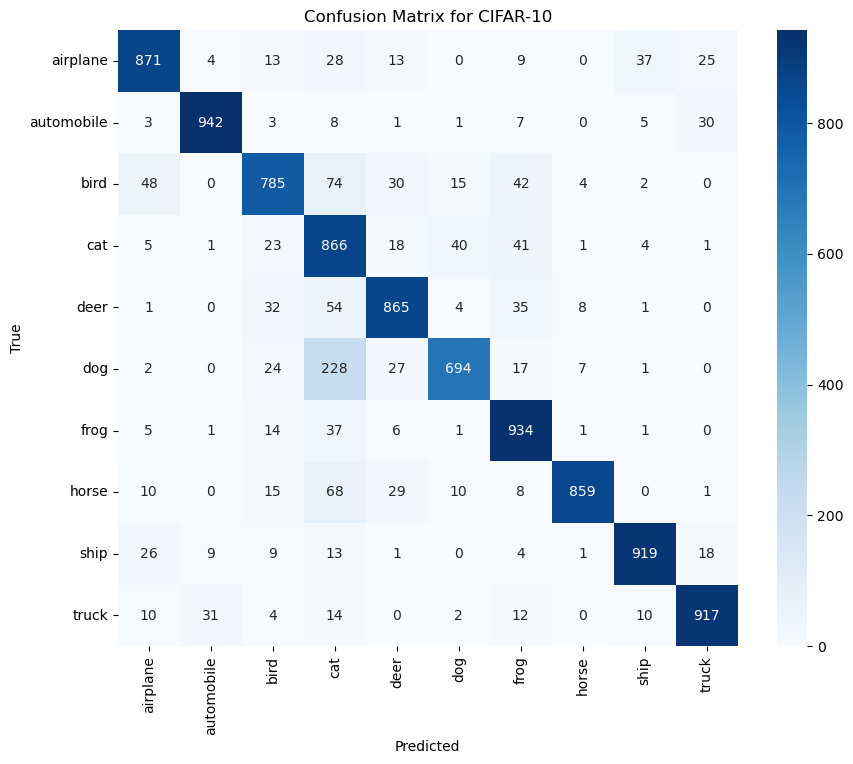

In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Unpickle function from CIFAR dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load all batches and combine
def load_cifar10_batches(path):
    batches = []
    labels = []
    for i in range(1, 6):  # CIFAR-10 has 5 training batches
        batch = unpickle(f'{path}/data_batch_{i}')
        batches.append(batch[b'data'])
        labels.append(batch[b'labels'])

    data = np.vstack(batches).reshape(-1, 3, 32, 32)  # Reshape to (num_samples, channels, height, width)
    labels = np.hstack(labels)

    test_batch = unpickle(f'{path}/test_batch')
    test_data = test_batch[b'data'].reshape(-1, 3, 32, 32)
    test_labels = np.array(test_batch[b'labels'])

    return data, labels, test_data, test_labels

# Load the CIFAR-10 data
train_data, train_labels, test_data, test_labels = load_cifar10_batches('./cifar-10-batches-py')

# Convert to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.float32) / 255.0
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_data = torch.tensor(test_data, dtype=torch.float32) / 255.0
test_labels = torch.tensor(test_labels, dtype=torch.long)

class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations (data augmentation)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize to CIFAR-10 mean/std
])

transform_test = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Test normalization
])


# Create dataset objects
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform_train)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform_test)


# Define the sample sizes
train_sample_size = 15000  # Adjust this as needed
test_sample_size = 5000     # Adjust this as needed

# Create random indices for the training and test datasets
train_indices = torch.randperm(len(train_dataset))[:train_sample_size]
test_indices = torch.randperm(len(test_dataset))[:test_sample_size]

# Create subsets
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# Create DataLoaders for the subsets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=0)




class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.4)

        # Second Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.4)

        # Third Convolutional Block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.5)

        # Fourth Convolutional Block (added for deeper network)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.4)

        # Fully Connected Layers
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)  # Adjusted to match new output size after the fourth block
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout_fc1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout_fc2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        # First Convolutional Block
        x = self.pool1(self.dropout1(self.bn2(F.relu(self.conv2(F.relu(self.bn1(self.conv1(x))))))))

        # Second Convolutional Block
        x = self.pool2(self.dropout2(self.bn4(F.relu(self.conv4(F.relu(self.bn3(self.conv3(x))))))))

        # Third Convolutional Block
        x = self.pool3(self.dropout3(self.bn6(F.relu(self.conv6(F.relu(self.bn5(self.conv5(x))))))))

        # Fourth Convolutional Block
        x = self.pool4(self.dropout4(self.bn8(F.relu(self.conv8(F.relu(self.bn7(self.conv7(x))))))))

        # Flatten for Fully Connected Layers
        x = x.view(-1, 512 * 2 * 2)

        # Fully Connected Layers
        x = self.dropout_fc1(self.bn_fc1(F.relu(self.fc1(x))))
        x = self.dropout_fc2(self.bn_fc2(F.relu(self.fc2(x))))
        x = self.fc3(x)

        return x



model = CIFAR10CNN()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-4)



import torch
from torchmetrics import Accuracy
import torch.nn as nn

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Initialize metrics
accuracy_metric = Accuracy(task='multiclass', num_classes=10).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()  # or your preferred loss function

num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    accuracy_metric.reset()  # Reset the accuracy metric at the start of each epoch

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        running_loss += loss.item()  # Accumulate loss

        # Update accuracy metric
        accuracy_metric(outputs, labels)

    # Get average loss and accuracy for this epoch
    average_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_metric.compute() * 100  # Convert to percentage

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Optional: Step with the scheduler if you are using one
    # scheduler.step(average_loss)

# Assuming `model` is your trained model
torch.save(model.state_dict(), 'model_weights.pth')

model = CIFAR10CNN()  # Initialize the model
model.load_state_dict(torch.load('model_weights.pth'))  # Load saved weights
# After training, evaluate on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking
    test_running_loss = 0.0
    accuracy_metric.reset()  # Reset accuracy metric for test set

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()  # Accumulate test loss
        accuracy_metric(outputs, labels)  # Update test accuracy

    test_average_loss = test_running_loss / len(test_loader)
    test_accuracy = accuracy_metric.compute() * 100  # Convert to percentage

    print(f'Test Loss: {test_average_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')





# Step 1: Make predictions on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Step 2: Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Step 3: Visualize the confusion matrix
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-10')
plt.show()



